# Practical Data Visualization with Python

By: [Paul Jeffries](https://twitter.com/ByPaulJ)

## High-Level Overview of Content:

In the section below you'll find a brief outline of the content contained in the four sections of this seminar. Thereafter, we'll go through a couple of setup steps, followed by the material for each of the four major sections. 

### Why We Visualize

1. The power of visual data representation and storytelling. 
2. A few principles and heuristics of visualization.
3. The building blocks of visualization explored.

### Overview of Python Visualization Landscape

1. Intro to the visualization ecosystem: python's Tower of Babel.
2. Smorgasbord of packages explored through a single example viz.
3. Quick & dirty (and subjective) heuristics for picking a visualization package.

### Statistical Visualization in the Wild

1. Example business use case of data visualization: debt-to-income ratios explored.
    1. Observational:
        - mean, median, and variance
        - distributions
    2. Inferential:
        - two-sample t-test
        - KS test

### Library Deep-Dive (Plotly)

1. Quick and simple data visualizations with Plotly Express.
    - Mark types, colors, facets, etc.
2. Additional control and complexity with base Plotly.
    - Choropleth maps 
    - Heatmaps 

## Setup

In [1]:
%%capture
# capturing above because there are a few useless warnings that might pop up, version-depending

# basic packages
import numpy as np
import pandas as pd
import datetime

# packages for viz
import plotly_express as px
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode()
from plotly import graph_objs as go
import altair as alt
alt.renderers.enable('jupyterlab')
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
from plotnine import *

In [2]:
# there are a few warnings I want to silence throughout that are due to unimportant np deprecations 
np.warnings.filterwarnings('ignore')

In [3]:
# store the datetime of the most recent running of this notebook as a form of a log
most_recent_run_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
f"This notebook was last executed on {most_recent_run_datetime}"

'This notebook was last executed on 2019-08-02 18:49'

In [4]:
# pulling in our main data; for more info on the data, see the "data_prep_nb.ipynb" file
main_df = pd.read_csv(filepath_or_buffer='../data/jan_and_dec_17_acqs.csv')

# taking a peek at our data
main_df.head()

loan_id orig_chn               seller_name  orig_rt  orig_amt  \
0  100020736692        B  CALIBER HOME LOANS, INC.    4.875    492000   
1  100036136334        R                     OTHER    2.750    190000   
2  100043912941        R                     OTHER    4.125     68000   
3  100057175226        R                     OTHER    4.990     71000   
4  100060715643        R                     OTHER    4.500    180000   

   orig_trm orig_dte frst_dte  oltv  ocltv  ...  occ_stat  state  zip_3  \
0       360  12/2017  02/2018    75     75  ...         I     CA    920   
1       180  12/2017  01/2018    67     67  ...         P     MD    206   
2       360  12/2017  02/2018    66     66  ...         P     OH    432   
3       360  12/2017  02/2018    95     95  ...         P     NC    278   
4       360  12/2017  02/2018    75     75  ...         I     WA    983   

  mi_pct product_type cscore_c  mi_type relocation_flg cscore_min  \
0    NaN          FRM      NaN      NaN              N      757.0   
1    NaN          FRM    798.0      NaN              N      797.0   
2    NaN          FRM      NaN      NaN              N      804.0   
3   30.0          FRM      NaN      1.0              N      696.0   
4    NaN          FRM      NaN      NaN              N      726.0   

        orig_val  
0  656000.000000  
1  283582.089552  
2  103030.303030  
3   74736.842105  
4  240000.000000  

[5 rows x 27 columns]

## Why We Visualize

**more detailed outline below until all the content can be added to the notebook**

- Intro comments about not just jumping into the sea of tools. 
    - Credit to [Jake VanderPlas' talk from PyCon 2019](https://www.youtube.com/watch?v=vTingdk_pVM).
- Slide about "Anscombe's Quartet" (see other repo)
- Updated slide with Dino Dozen dataset.
- So what did we really "do" when we visualized these data points in order to glean additional information?
    - Answer to "why we visualize?": because encoding data into a visual representation can often lead to insights that we might not glean intuitively, if at all, without visualization. 
- Show an example of encoding: dino dozen, with X, Y, and color.
    - Follow that with an example of many potential encodings (facet, size, shape, color, all-in-one)
- Go over Bertin's book on encodings, and levels of organization, recognizing what types of encodings are better suited for communicating different levels of information. 
    - Bertin or VanderPlas' lists though are not exhaustive, nor should they be taken as irrefutable. It's the concept that matters. 
    - Before starting a visualization one should always ask:
        - What type of information am I trying to encode?
        - As such, what type of ecoding would most clearly and powerfully communicate that information?
        - Simple heuristic here that I find helpful: does the design of this visualization call the attention of the observer seemlessly to the most important features of the dataset
- Putting it all together with the "building blocks of visualization":
    - Data
    - Transformation
    - Marks
    - Encoding
    - Scale
    - Guides
    - Reference here to L. Wilkinson's book and Hadley's Book
    - Provide example highlighting each of the above building blocks
- Ending example with Fannie Mae data of a visualization problem with one mediocre solution and one good one:
    - Problem of FICO distributions by lender. 

### Theory Before Packages

...

### Dissection of a Visualization: Two Examples Explored

Now that we have explored the building blocks of visualization and learned some heuristics to help us with best practices, let's apply this to an example use case.

Imagine that one of our risk managers wants to understand the FICO distributions of a handful of lenders. They've also added that all they really care about is understanding the relative distributional differences: i.e., how does lender 1's distribution differ from lender 2's, and so on. For the sake of this analysis, we'll just (arbitrarily) pick the top 3 lenders by January 2017 origination volume. 

How might you go about visualizing these distributional differences? We'll start with an example of a mediocre visualization that, while helpful, is likely not optimal given the ask. Then we'll proceed to a better visualization that more powerfully and clearly communicates the information we want. 

In [5]:
# pre-visualization data prep:
# creating a df with just the january origination volume of our top 10 lenders by volume in that month

# filtering to just january acquisitions and dropping "OTHER" sellers
jan_originations_only = main_df.loc[(main_df['orig_dte'] == '01/2017') & (main_df['seller_name'] != 'OTHER'),:]

# getting the top 3 lenders by volume
top_3_lenders = (
    jan_originations_only
    .groupby('seller_name')
    .size()
    .reset_index(name='counts')
    .sort_values('counts', ascending=False)
    .head(3)
)['seller_name']

# making a df of just the records from the top 3 lenders by volume, keeping just the needed columns: seller name and FICO
top_3_lenders_jan_origs_df = jan_originations_only.loc[main_df['seller_name'].isin(top_3_lenders),['seller_name','cscore_min']]

# inspecting the data we'll be working with for this example
top_3_lenders_jan_origs_df.head()

seller_name  cscore_min
2803   JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       724.0
3208   JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       744.0
8514   JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       695.0
10496  JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       738.0
10788  JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       701.0

Below is an example of a mediocre 1st pass at the visualization problem described above. For this viz. I'll make use of the [Plotly Express](https://plot.ly/python/plotly-express/) package (more on this later; the purpose of this section isn't to focus on package-specific idosyncracies) to make 3 FICO histograms--one for each seller. 

- Some of the weaknesses of this viz include:
    - All of the "sloppy" legend work:
        - lack of title
        - sloppy labels (facets, x-axis, y-axis)
    - Use of histogram (counts) makes it harder to compare the overall FICO distributions because volume differences can be distracting.
    - Use of facets complicates comparisons by forcing "bouncing eyes".

In [6]:
# medicore example -- facetted histogram:

# creates a histogram facetted by seller with Plotly Express
lender_fico_hist = px.histogram(
    data_frame = top_3_lenders_jan_origs_df,
    x = 'cscore_min',
    color = 'seller_name',
    facet_col = 'seller_name',
    height = 600,
    width = 1200
)

# dropping the color legend
lender_fico_hist.update(
    layout_showlegend=False,
)

In [7]:
# saving out the px figure; I'm doing this in a separate cell because saving plotly figures requires orca, which some might not have
# for details on how to get orca working, see: https://medium.com/@plotlygraphs/plotly-py-end-of-summer-updates-5422c98b9058
pio.write_image(lender_fico_hist, file='../media/fico_seller_hist_plot.png')

Below is an example of a crisper representation of the data in our use case. I'll make use of kernel density plot ([aka PDF](https://en.wikipedia.org/wiki/Probability_density_function)), which is a great chart type if you care about looking at the overall shape of distributions. For now, it's not important to fully understand the math behind the smoothing visible in the KDE plot, but if you're interested, check out [this explanation of the meaning of the y-axis](https://stats.stackexchange.com/questions/48109/what-does-the-y-axis-in-a-kernel-density-plot-mean), as well as this [overall explanation of KDE plots](https://www.homeworkhelponline.net/blog/math/tutorial-kde). The quick tl:dr is that if you pick two points along the x-axis, the area under the curve between them is the probabilty of finding a value in that range (or in empirical cases, the actual observed rate of occurence of a value in that range), but again, given the stated problem in this use case, those details are less important than the overall shape of the distributions. 

- Some of the strengths of this viz include:
    - The use of color hue makes it easy to differenciate between sellers at a glance.
    - The lack of facets and shared scale facilitates relative comparisons of the distributions by avoiding "bouncing eyes".
    - The choice of a KDE plot as the mark type removes the noise inherent to a histogram.

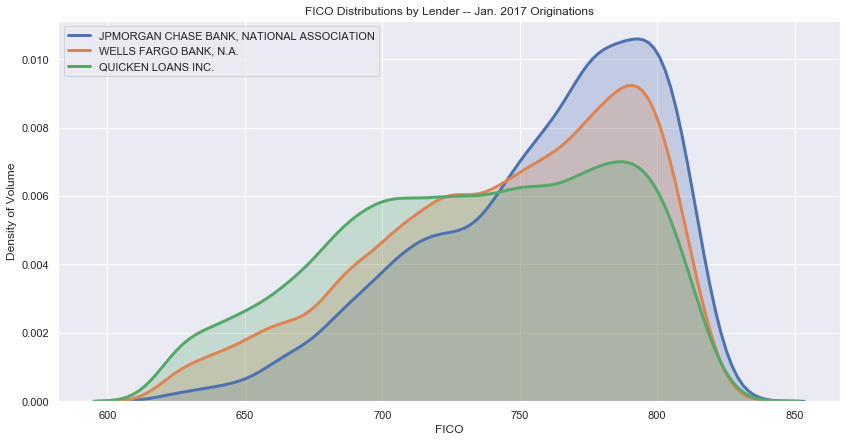

In [8]:
# higher-quality viz. example -- overlayed KDE plot:

# setting our figure size
plt.figure(figsize=(14, 7))

# plotting one KDE plot for each seller
for seller in top_3_lenders_jan_origs_df['seller_name'].unique() :
    fico_dist_ax = sns.distplot(
        top_3_lenders_jan_origs_df.loc[top_3_lenders_jan_origs_df['seller_name']== seller,'cscore_min'],
        hist = False,
        kde = True,
        kde_kws = {
            'shade': True,
            'linewidth':3
        },
        label = seller
    )
;

# setting the axes labels and title
fico_dist_ax.set(
    xlabel="FICO", 
    ylabel="Density of Volume", 
    title ="FICO Distributions by Lender -- Jan. 2017 Originations"
)

;
# saving out the plot
plt.savefig(fname = '../media/fico_seller_dist_plot.png')

## Overview of Python Visualization Landscape 

Now that we've learned some heuristics and best practices to help us craft clear and powerfully informative visualizations, let's dive into a broad overview of the smorgasboard of libraries that exist in the python ecosystem to help us build visualizations. 

### Intro to the visualization ecosystem: python's Tower of Babel.

### Smorgasbord of packages explored through a single example viz.

In this section, we'll take a relatively simple chart type and explore how it can be built using a variety of the most common visualization packages in the Python ecosystem today. Each example will be accompanied by a link to the relevant documentation, as well as some brief commentary about the structure of the package's API. The packages for which we'll be building example plots are:

- plotly
- altair
- bokeh
- plotnine
- matplotlib
- seaborn

The chart that we'll build is a **scatterplot of FICO vs. LTV colored by lender**. More specifically, we'll be using a down-sampled (for speed and simplicity) version of the previously-explored df of data from the top 3 lenders by volume, retaining the LTV variable in addition to seller name and credit score. We'll start as always by buliding our needed dataset, and then we'll dive into the example visualizations for each package.

**Note:** for each of the examples below, we won't necessarily be building the optimal chart, but rather focusing on demonstrating the basic functionality of each library's API structure. As such, there will, with each chart, likely be margin for improvement--better-formatted legends, axis labels, etc.--but they serve as an example of a [standard MVP](https://en.wikipedia.org/wiki/Minimum_viable_product) from each library. 

In [9]:
# making a df of just the records from the top 3 lenders by volume, keeping just the needed columns: seller name, FICO, and LTV
downsamp_top_3_lenders_df = (
    jan_originations_only
    .loc[main_df['seller_name']
    .isin(top_3_lenders),['seller_name','cscore_min','oltv']]
    .sample(frac = 0.1)
)

# inspecting the data we'll be working with for this example
downsamp_top_3_lenders_df.head()

seller_name  cscore_min  oltv
48208                      WELLS FARGO BANK, N.A.       786.0    54
44127   JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       756.0    80
43561                      WELLS FARGO BANK, N.A.       729.0    70
124555                         QUICKEN LOANS INC.       785.0    63
44423                      WELLS FARGO BANK, N.A.       787.0    80

**Plotly Example:**

- [Link to documentation here](https://plot.ly/python/plotly-express/).
- With plotly express, the full figure is created with a single call to `px.scatter()`. 
- Note that column names are passed as text to the x and y params, etc. 

In [10]:
# single call to px.scatter creates the plotly express figure
basic_plotly_fig = px.scatter(
    # select data frame of reference
    data_frame = downsamp_top_3_lenders_df, 
    # column name of x-axis data
    x="oltv", 
    # column name of y-axis data
    y="cscore_min", 
    # column name of categories to use for colors
    color="seller_name",
    # text to be used for chart title
    title = "Basic Plotly Scatterplot"
)

# displays the chart in-line
basic_plotly_fig

# saving out the plot
plot(
    figure_or_data = basic_plotly_fig, 
    filename="../media/basic_plotly_fig.html", 
    auto_open=False
);

**Altair Example**:
    
- [Link to documentation here](https://altair-viz.github.io/gallery/scatter_tooltips.html).
- Note the multiple methods involved, and the explicit language of encoding / grammar of graphics.
- Encodings composed of column names and `:<type_of_encoding>`, implicitly or explicitly (e.g. `:Q` = quantitative).
- Interactivity turned on by separate method.
- Note the fact that if we want to not include 0 (i.e. we want axes to auto-scale) that must be called manually.
- Saving out PNGs of Altair-made charts can be a bit of pain, as it requires [chromedriver](https://sites.google.com/a/chromium.org/chromedriver/home), so I'm not going to show that here.

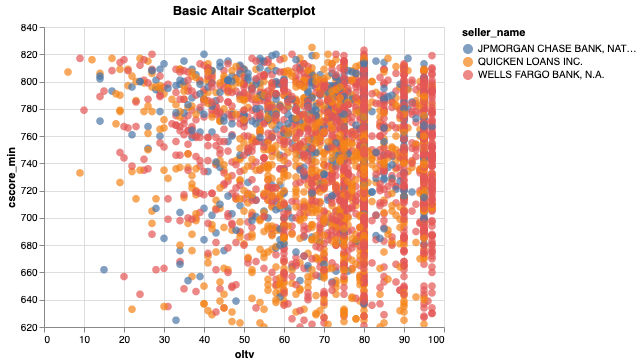

In [11]:
# altair plot construction starts by specifying the df to be charted 
basic_altair_fig = (alt.Chart(downsamp_top_3_lenders_df)
 # next we specify mark type
 .mark_circle(size=60)
 # then we provide details for the encoding
 .encode(
    # the after-colon leters specify variable type (quantitative, nominal, etc.)
    x='oltv:Q',
    y = alt.Y('cscore_min:Q', scale=alt.Scale(zero=False)),
    color= 'seller_name:N'
)
 # interactivity specified separately
 .interactive()
 # title included via separate call to properties
).properties(
    title='Basic Altair Scatterplot'
)

# displays the chart in-line
basic_altair_fig

# saving out the plot
# not running this due to chromedriver dependency described above
# basic_altair_fig.save('../media/basic_matplotlib_fig.png')

**Bokeh Example:**

- [Link to documentation here](https://bokeh.pydata.org/en/latest/docs/gallery/color_scatter.html)
- Note that categorical coloring cannot be derived simply from a call to the API, but must be pre-specified.
- Title and other properties are specified at the point of instantiation of the figure or added after the fact.
- Bouncing back and forth between interative bokeh viewing and saving bokehs out can be troublesome at times, [as described here](https://stackoverflow.com/questions/51512907/how-to-stop-bokeh-from-opening-a-new-tab-in-jupyter-notebook).

In [12]:
# because bokeh doesn't derive categorical colors, we need to create a new column to color based on lender
# we'll do this with the custom function below
def set_color(row):
    if row['seller_name'] == 'WELLS FARGO BANK, N.A.':
        return "red"
    elif row['seller_name'] == 'QUICKEN LOANS INC.':
        return "blue"
    else:
        return "green"

# updating the df to include a new column for color
downsamp_top_3_lenders_df = (
    downsamp_top_3_lenders_df
    .assign(manual_color = downsamp_top_3_lenders_df.apply(set_color, axis=1))
)

# inspecting the new df we'll need to make the bokeh plot
downsamp_top_3_lenders_df.head()

seller_name  cscore_min  oltv  \
48208                      WELLS FARGO BANK, N.A.       786.0    54   
44127   JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       756.0    80   
43561                      WELLS FARGO BANK, N.A.       729.0    70   
124555                         QUICKEN LOANS INC.       785.0    63   
44423                      WELLS FARGO BANK, N.A.       787.0    80   

       manual_color  
48208           red  
44127         green  
43561           red  
124555         blue  
44423           red

In [13]:
# begin by defining the figure space
basic_bokeh_fig = figure(title = "Basic Bokeh Scatterplot", plot_width=400, plot_height=400)

# now that we have our colors set correctly, we can make the plot with one call to the circle renderer
basic_bokeh_fig.circle(
    x = downsamp_top_3_lenders_df['oltv'], 
    y = downsamp_top_3_lenders_df['cscore_min'],
    color = downsamp_top_3_lenders_df['manual_color']
)

# displays the chart in-line
output_notebook()
show(basic_bokeh_fig)

# saving out the plot
output_file('../media/basic_bokeh_fig.html')
save(basic_bokeh_fig);

Loading BokehJS ...

**Plotnine Example:**

- [Link to documentation here](https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_point.html).
- Copy of [ggplot syntax](https://ggplot2.tidyverse.org/reference/ggplot.html) almost exactly.
- Note that some arguments are purely positional.

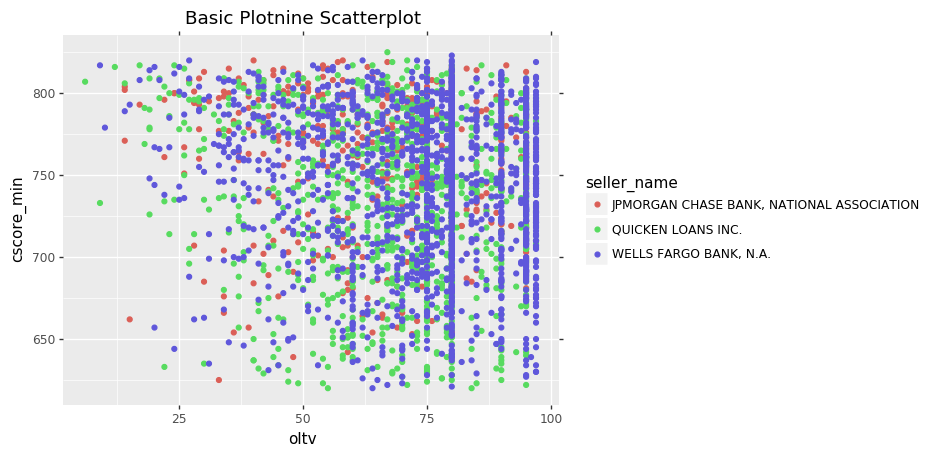

In [14]:
# building the viz starts with call to ggplot with other features added with '+'
basic_plotnine_fig = (ggplot(
    # specifying aesthetics as done with ggplot
    # data comes positionally after aes
    aes(x='oltv', y='cscore_min', color = 'seller_name'), data = downsamp_top_3_lenders_df)
    # specifies scatterplot with geom type
    + geom_point() 
    # adding title
    + ggtitle("Basic Plotnine Scatterplot")
    )

# displays the chart in-line
basic_plotnine_fig.draw();

# saving out the plot
basic_plotnine_fig.save(filename='../media/basic_plotnine_fig.png')

**Matplotlib Example:**

- [Link to documentation here](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html).
- Just as we saw with Bokeh, colors cannot be passed to the `plt.scatter()` call by way of a categorical label; they must be pre-specified. [Here is another way](https://stackoverflow.com/questions/8202605/matplotlib-scatterplot-colour-as-a-function-of-a-third-variable) to do this. 
- Note how heavily manual matplotlib is: there are no default axis labels unless specified. This makes matplotlib, while perhaps the most customizable of all the main python plotting libraries, also the most manual.
- Note that the data behind the chart are series that don't need to come from a single dataframe. 

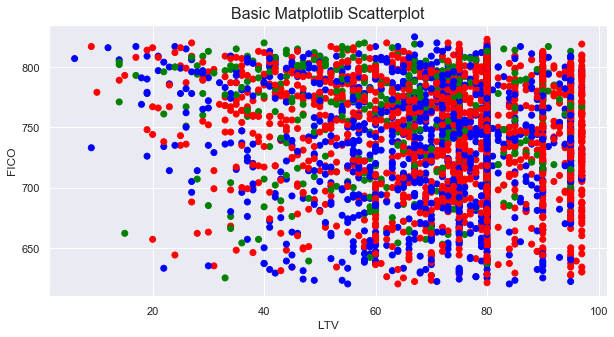

In [15]:
# setting our figure size
plt.figure(figsize=(10, 5))

# constructing the scatterplot with a call to plt.scatter()
basic_matplotlib_fig = plt.scatter(
    x = downsamp_top_3_lenders_df.loc[:,'oltv'], 
    y = downsamp_top_3_lenders_df.loc[:,'cscore_min'],
    # colors specified manually as described above; a label won't work here
    c = downsamp_top_3_lenders_df.loc[:,'manual_color']
)

# adding some basic chart properties--labels and title
plt.xlabel('LTV', fontsize=12)
plt.ylabel('FICO', fontsize=12)
plt.title('Basic Matplotlib Scatterplot', fontsize = 16)

# displays the chart in-line
basic_matplotlib_fig;

# saving out the plot
plt.savefig(fname = '../media/basic_matplotlib_fig.png')

**Seaborn Example:**

- [Link to documentation here](https://seaborn.pydata.org/generated/seaborn.scatterplot.html).
- Note the similarities to matplotlib; it's essentially like matplotlib with more abstractions for convenience.
- Unlike matplotlib, however, the calls to base functions like `sns.scatterplot()` do take a df as an argument.

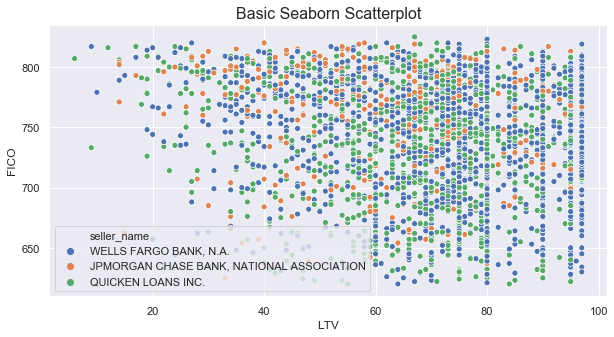

In [16]:
# setting our figure size
plt.figure(figsize=(10, 5))

# creating the figure / axes with a call to sns.scatterplot()
basic_seaborn_fig = sns.scatterplot(
    data = downsamp_top_3_lenders_df, 
    x="oltv", 
    y="cscore_min", 
    hue = 'seller_name'
)

# setting the axes labels and title
plt.xlabel('LTV', fontsize=12)
plt.ylabel('FICO', fontsize=12)
plt.title('Basic Seaborn Scatterplot', fontsize = 16)

# displays the chart in-line
basic_seaborn_fig;

# saving out the plot
plt.savefig(fname = '../media/basic_seaborn_fig.png')

### Quick & dirty (and subjective) heuristics for picking a visualization package.

## Statistical Visualization in the Wild

Having explored some of the vast menu of libraries available to us when building visualizations with python, let's see how we might approach a larger business question by combining statistical techniques with visualization. 

Imagine that your team has received a request from a business partner asking for your help in understanding how [debt-to-income (DTI) ratios](https://www.consumerfinance.gov/ask-cfpb/what-is-a-debt-to-income-ratio-why-is-the-43-debt-to-income-ratio-important-en-1791/) have changed over the course of 2017. While it might be optimal to make use of data from the full 2017 calendar year here, for the sake of this example, we'll stick with the same data we've been using throughout this seminar: January and December 2017 originations. How should we proceed?

For the sake of this vignette, we'll proceed in a way similar to how we might on the job. With a decently open-ended question like this, it's best to start with some [exploratory data analysis (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis). Once we have built some intuition surrounding the problem by way of thoughtful EDA, we might then proceed to run some statistical tests and/or maybe build a model that will allow us to more powerfully communicate insights to our partners. Let's get to it!


### Exploratory and Observational Statistics and Visualizations

Given that our question boils down to the evolution of DTI between January and December 2017 originations, a wise place to start out EDA journey would be to get our feet wet with some simple summary statistics. This means we'll want to start by looking at things like the mean and median DTIs in the two months of data we have, along with some measures of variance / spread. Of course, we'll want to craft visualizations along the way that intuitively communicate this information as well. Next, we'll want to try to visualize the fuller distribution of DTI beyond relying on simple summary statistics. 

Before diving into the above, we'll want to prepare the data we'll be working with for this section. While in a real-world scenario, we would of course want to consider the interplay between other variables and DTI when investigating its evolution over time, for the purpose of keeping this vignette simple, we'll restrict our analysis to purely considering DTI and origination date as our two variables of interest. 

In [17]:
# creating a dataset with just origination date and DTI to simplify our data-wrangling for this section
dti_df = main_df.loc[:,['orig_dte','dti']]

# taking a look at the data we'll be working with for this section
dti_df.head()

orig_dte   dti
0  12/2017  44.0
1  12/2017  37.0
2  12/2017  17.0
3  12/2017  25.0
4  12/2017  28.0

In [18]:
# to-do here: calculate summary stats for DTI split by origination date

In [19]:
# to-do here: build a visualization or two to communicate the aforementioned summary stats

# e.g. violin plots, box-and-whisker (all available in plotly / px, but feel free to use whatever)

Now that we've looked into some summary stats, let's look at the distro blah blah blah... 

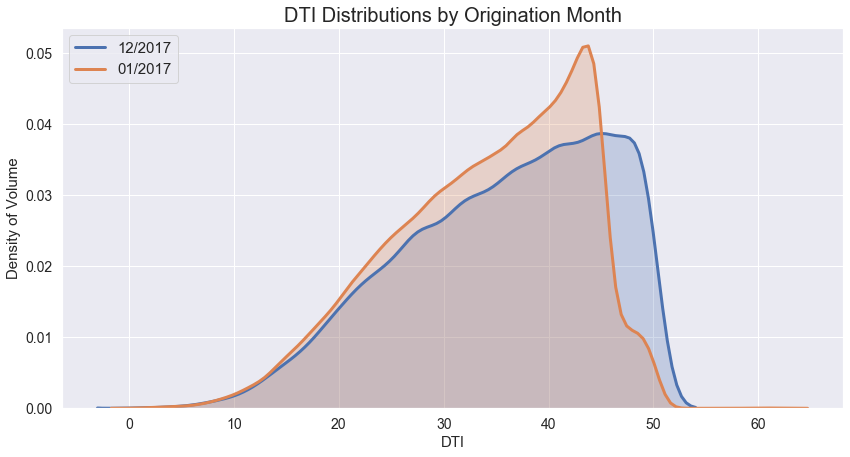

In [20]:
# building a KDE plot to compare DTI in the two origination months:

# setting our figure size
plt.figure(figsize=(14, 7))

# plotting one KDE plot for each seller
for origination_date in dti_df['orig_dte'].unique() :
    dti_dist_ax = sns.distplot(
        dti_df.loc[dti_df['orig_dte']== origination_date,'dti'],
        hist = False,
        kde = True,
        kde_kws = {
            'shade': True,
            'linewidth':3
        },
        label = origination_date
    )
;

# taking care of a few final aesthetic tweaks: 
# setting the axes labels and title
dti_dist_ax.set(
    xlabel="DTI", 
    ylabel="Density of Volume", 
    title ="DTI Distributions by Origination Month"
)
# specifying the legend location and size, and tweaking other font sizes
dti_dist_ax.legend(loc=2, prop={'size': 15})
dti_dist_ax.yaxis.label.set_size(15)
dti_dist_ax.xaxis.label.set_size(15)
dti_dist_ax.title.set_size(20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

;
# saving out the plot
plt.savefig(fname = '../media/dti_origmonth_dist_plot.png')

### Inferential Stats and Visualizations

Now that we have gleaned some insights from our EDA, it's time to explore some statistical tests to better probe the differences between DTI between January and December 2017.

In [21]:
# to-do here: two-sample t-test to test the difference in mean DTI between the two months
# feel free to do this the frequentist way (closed form calc from a package) or the bayesian way (simulation / "hacker stats") -- bonus points for both?

In [22]:
# to-do here: visualize the two-sample t-test above:
# show the confidence interval, shade the p-value

In [23]:
# to-do here: run a KS test to test the difference between both distributions

In [24]:
# to-do here: explain the KS test with multiple visualizations
# the KS test stat is just the max distance of separation between two ECDFs...
# we already showed the PDF above, so first, just plot the ECDF of the two distros
# it would be great if we could also draw a line showing the KS test itself--i.e. a veritical line between two ECDFs at the point of max separation

In [25]:
# to-do here: think of any other test or model to build to look into the DTI difference between these two months... 

## Library Deep-Dive (Plotly)

Having now covered some of the more theoretical components of a robust data visualization toolkit, explored the menu of package options from which one can choose, and gone through a few examples of statistical visualization problems one might face on the job, it seemed apposite to round out this material with a deep-dive into a particular package. There are a few reasons for doing this with [Plotly](https://plot.ly/python/) specifically:

1. Popularity of Plotly
    - Plotly is a popular suite of visualization options for python and R uses alike. 
2. Synergies between Plotly and Dash
    - Plotly plays nicely with [Dash](https://plot.ly/dash/)--a popular python web app framework.
3. Reinforces a Key Skill: Hunting Through Documentation
    - Plotly is a vast library with documentation that varies in degrees of ease of use, so it is an excellent package with which to hone one's skills at navigating documentation to find the answer you need. 
    
Plotly is, as of March of 2019, more than one library. I'm simplifying a bit here for the sake of concision, but there are essentially two main variants of Plotly visualizations: base Plotly, and [Plotly Express](https://medium.com/@plotlygraphs/introducing-plotly-express-808df010143d). We'll dive into both here shortly, but suffice it to say that the names do a decent job of explaining what differentiates both packages: base Plotly allows the user a high degree of customizability in crafting a wide array of interactive javascript-based visualizations. Plotly Express takes much of the functionality of base Plotly, but simplifies the API a great deal at the cost of sacrificing some small degree of customizability.

Now, we'll jump into examples for both.

### Plotly Express

In describing Plotly Express, I don't think one can do better than the [announcement post](https://medium.com/@plotlygraphs/introducing-plotly-express-808df010143d) for the package:

> Plotly Express is a new high-level Python visualization library: it’s a wrapper for Plotly.py that exposes a simple syntax for complex charts. Inspired by Seaborn and ggplot2, it was specifically designed to have a terse, consistent and easy-to-learn API: with just a single import, you can make richly interactive plots in just a single function call, including faceting, maps, animations, and trendlines.

My personal take then, is that Plotly Express is, simply put, Plotly's competitor to [Seaborn](https://seaborn.pydata.org/). It is particularly well-suited for visualization problems where the chart / mark-type you need isn't very niche. Differently put, if you are looking to build a very particular type of choropleth map, for example, stick with base Plotly (or some other package), as we will later in this material. If, on the other hand, you want to make a bar chart, scatter plot, etc. (see a fuller yet not exhaustive [list of potential chart types here](https://plot.ly/python/plotly-express/)), Plotly Express is a great tool to leverage. If you are looking for more of a walkthrough to Plotly Express, [see here](https://nbviewer.jupyter.org/github/plotly/plotly_express/blob/gh-pages/walkthrough.ipynb?source=post_page---------------------------) for that type of documentation as well. Also, note that Plotly, like most packages, is constantly evolving. As one example of this, a [recently released updated for Plotly -- Plotly 4.0](https://medium.com/@plotlygraphs/plotly-py-4-0-is-here-offline-only-express-first-displayable-anywhere-fc444e5659ee) -- will impact how we go about updating things like Plotly Express layouts, etc. As such, it pays to keep an ear to the ground with respect to package updates and best practices. 

Finally, note that if you are trying to trouble-shoot or explore with Plotly Express, my preferred source of help is always the official [Plotly Express documentation](https://www.plotly.express/plotly_express/). If the docs fail you, you can of course always try `?name_of_plotly_function_here`, and last but certainly the most hacky of solutions: you can make up parameters within the function that you know don't exist, as sometimes the error traceback that will result can yield yelpful insights about allowable values, etc.
 
Now, let's jump into a deeper exploration of Plotly Express by diving into the details of the facetted histogram we briefly went over early in this material, dissecting the various components, and also improving on / [updating it](https://plot.ly/python/creating-and-updating-figures/
).

In [26]:
# dissection of a histogram with Plotly Express
lender_fico_hist = px.histogram(
    # data frame containing the data for this plot
    data_frame = top_3_lenders_jan_origs_df,
    # variable to be plotted on the x-axis
    x = 'cscore_min',
    # variable to be used to determine color of the bars
    color = 'seller_name',
    # variable to split on for facets; in this case, we'll facet across columns
    facet_col = 'seller_name',
    # number of bins to use--somewhat arbitrary; google "histogram binning bias" to learn more
    nbins = 100,
    # title for the entire chart
    title = "FICO Histogram by Lender (January 2017)",
    # figure output height and width in pixels; will autoscale if just given 1 value 
    height = 600,
    width = 1200
)

# note that what we add on to the plot here with "update" statements is NOT available in the base px.histogram parameters
(lender_fico_hist
 # change x-axis label
 .update_xaxes(title = "FICO")
 # change y-axis label
 .update_yaxes(title = "Loan Count")
)

While we've made a few improvements to the chart--axis labels, title, etc.--I still don't like the legend location or the facet labels. How would I go about fixing this? Well... if we go to [the documentation for Plotly Express barcharts](https://www.plotly.express/plotly_express/#plotly_express.bar), we don't see anything about legends. Now what? 

We'll, I would start by digging into the anatomy of our specific chart by calling `?lender_fico_hist`, and we'll begin to see what lies beneath the Plotly Express API. We'll see Some basic information about the object, for example: it is of type "Express Figure", and under "Init docstring:" we start to see how it is made.

![](../media/inspecting_top_of_px_figure.jpg)

---

Then, if we look a bit further down in the output, we'll start to see the two main components that make up a Plotly figure (both Express, and otherwise): the `data` and the `layout` options. 

![](../media/inspecting_parameters_px_figure.jpg)

---

Everything listed under `layout` ... `Supporting dict properties:` let's you see all of the layout parameters that could be callable! There are a lot of them, for sure. Remeber, we're looking to learn about how to mess with the legend, so we scroll through these properties until we get to `legend`, as shown below. 

![](../media/inspecting_legend_param_px_figure.jpg)

---

From this, we can tell that there is a legend parameter that is a part of this figure's layout and that is callable as a dictionnary... but what value within that dictionnary controls the legend's location? Well, for that, I kid you not, the most tried and true method I have discovered is to guess, and read the error traceback. For example, I might write the chunk of code below...

![](../media/purposefully_breaking_pxcode_layout.jpg)

---

Which will ultimately throw an error containing, among other things this traceback here:

![](../media/px_error_layout_traceback.jpg)

Eureka! A list of parameteres that our legend dictionnary can take, a few of which have to deal with the legend's location. We can thus apply this guess-and-check method to fix the chart as we'd like, arriving at the following layout updates below.

In [27]:
# now that we've found the right layout and legend parameters, we have what we need to move the legend where we want it:
(lender_fico_hist
 # change the layout's location
 .update(
     layout = dict(
         legend = dict(
             # pick the x and y coords manually (bounded between [-2,3])
             x = 1,
             y = 1.25
         )
     )
 )
)

After all of that work, howeover, our chart labels still don't look as we'd like. As it turns out, this is one of the areas where the Plotly API, no matter how deep we go in the docstrings, doesn't afford us the flexibility we might want. As such, in order to clean up the labels for both the facets and the color legend, we'll need to transform our starting data slight--something that is actually quite common when making a custom viz. This just goes to show that **sometimes it is better to transform your data to suit the API, than to force the API to do something it wasn't designed to do.**

In [28]:
# making a copy of our df that we'll use just for the purpose of this viz
vizready_top_3_lender_df = top_3_lenders_jan_origs_df

# defining a function that we'll apply over our existing df to rename the banks to shorter labels
def big_three_bank_labeler (row):
   if row['seller_name'] == 'JPMORGAN CHASE BANK, NATIONAL ASSOCIATION':
      return 'JPMorgan'
   if row['seller_name'] == 'WELLS FARGO BANK, N.A.':
      return 'Wells'
   if row['seller_name'] == 'QUICKEN LOANS INC.':
      return 'Quicken'

# applying our custom labeling function
vizready_top_3_lender_df['Lender'] = vizready_top_3_lender_df.apply(big_three_bank_labeler, axis=1)

# inspecting the results
vizready_top_3_lender_df.head()

seller_name  cscore_min    Lender
2803   JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       724.0  JPMorgan
3208   JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       744.0  JPMorgan
8514   JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       695.0  JPMorgan
10496  JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       738.0  JPMorgan
10788  JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       701.0  JPMorgan

Now that we have transformed our data to suit the constraints of our API, after having throughougly explored the various options and paramters with which we can work, let's dive into the creation of the final viz. 

In [29]:
# final histogram with all parameters and layout options we want integrated
lender_fico_hist = (
    px.histogram(
    # data frame containing the data for this plot
    data_frame = vizready_top_3_lender_df,
    # variable to be plotted on the x-axis
    x = 'cscore_min',
    # variable to be used to determine color of the bars
    color = 'Lender',
    # variable to split on for facets; in this case, we'll facet across columns
    facet_col = 'Lender',
    # number of bins to use--somewhat arbitrary; google "histogram binning bias" to learn more
    nbins = 100,
    # title for the entire chart
    title = "FICO Histogram by Lender (January 2017)",
    # figure output height and width in pixels; will autoscale if just given 1 value 
    height = 600,
    width = 1200
    )
    # making edits to layout
    # specifying x-axis label
    .update_xaxes(title = "FICO")
    # specifiying y-axis label
    .update_yaxes(title = "Loan Count")
    # specifying location of the legend (under genderal layout)
    .update(
     layout = dict(
         legend = dict(
             # pick the x and y coords manually (bounded between [-2,3])
             x = 0.75,
             y = 1.25
         )
     )
 )
)

# calling the figure so it will display inline
# we can also save out the png as shown above with plotly.io
lender_fico_hist

After all of this, one final thought you might have could be: isn't it redundant to have the facet labels say the exact same thing as the legend? Yes! The tough part about that is that there simply isn't a parameter or an update method as of yet that exists to deal with hiding these labels. This isn't something that is intuitive, either. Rather, after a long journey through [the docs](https://plot.ly/python/reference/), I eventually went with the nuclear option (not recommended) and simply tweeted at the head of product for Plotly about this, and [he very graciously responded](https://twitter.com/nicolaskruchten/status/1153472636745396224?s=20), as shown below. As Nicolas shows us, the only way to deal with this is by dropping all annotations (for now; an update method is in the works). 

![](../media/tweet_at_plotly_devs_response.jpg)

The lesson here is not to tweet at package devs whenever you encouter a problem, but rather to build a community around you to whom you can turn for answers when you hit a particularly hard problem.

In [30]:
# implementing fix recommended by Nicolas to drop facet labels
lender_fico_hist.layout.annotations = []

# displaying the final draft of our output
lender_fico_hist

In [31]:
# the figure can also be saved out in html format, as can all Plotlys...
# using the plotly.offline function "plot"
plot(
    figure_or_data = lender_fico_hist, 
    filename="../media/lender_fico_hist.html", 
    auto_open=False
);

### Base Plotly 

Now that we've explored the wonders of Plotly Express, a logical question would be: why bother returning to base Plotly given all the functionality of Plotly Express? Well, there are two mains answers to that question:

- Access to certain figure types that are non achievable (yet, to my knowledge) with Plotly Express
    - Some figure varieties are so domain-specific or otherwise niche that there simply isn't yet a Plotly Express API built to produce that particular variety of viz, for example, the [quiver plot](https://plot.ly/python/v3/quiver-plots/)
    - The example we'll go over pertaining to this justification entails exploring the creation of [distribution plots (aka distplots)](https://plot.ly/python/distplot/) with Plotly's [figure factory](https://plot.ly/python/figure-factory-subplots/#plotlys-figure-factory-module), where chart types go prior to being integrated into the broader Plotly.js library of plot types. 
- Less abstraction in syntax = more granular control over all details of the viz
    - Think about how, as we went through the Plotly Express examples, we had to dig into the skeletal structure of the plot (Data and Layout) in order to find what parameters we might be able to pass to an `update()` method call to get our desired plot. With base plotly, we start out at this level of detail, which is both more work, but also more all-encompassing from the get-go. 
    - The example we'll go over pertaining to this justification entails creating a custom heatmap.


**Note of Clarification:** When mentioning "base Plotly", I am referring to everything in the Plotly ecosystem that is not Plotly Express. Generally, this entails Plotly ["Graphical Objects" (aka "Go")](https://plot.ly/python/creating-and-updating-figures/#figures-as-graph-objects) and the aforementioned Plotly ["Figure Factory" (aka "FF")](https://plot.ly/python/figure-factory-subplots/). If Plotly Express is mostly used as the quickest way to interact with Plotly visualizations, you can think of Go as the largest overarching granular framework for making most any plot type with Plotly, and Figure Factory as a more experimental branch of the Plotly API, as previously described. 

With all that context in mind, let's jump into exploring these aforementioned example use cases for base Plotly, below.

In [32]:
# building a distribution plot of FICO distributions by lender using the Plotly figure factory

# transforming the data in the manner that the ff API prefers
# making one vector for Lender's each FICO distribution, downsampling (5%) for speed purposes, and dropping any NAs
jpm_fico_distro = (
    vizready_top_3_lender_df
    .loc[vizready_top_3_lender_df['Lender']=='JPMorgan','cscore_min']
    .dropna()
    .sample(frac = 0.05)
)
wells_fico_distro = (
    vizready_top_3_lender_df
    .loc[vizready_top_3_lender_df['Lender']=='Wells','cscore_min']
    .dropna()
    .sample(frac = 0.05)
)
quick_fico_distro = (
    vizready_top_3_lender_df
    .loc[vizready_top_3_lender_df['Lender']=='Quicken','cscore_min']
    .dropna()
    .sample(frac = 0.05)
)

# grouping the data into an array, per the API's preferences
fico_distro_data = [jpm_fico_distro, wells_fico_distro, quick_fico_distro]
# adding labels positionally, again per the API's preferences
group_labels = ['JPM', 'Wells', 'Quicken']

# create distplot with a PDF curve and rug plot
lender_fico_distplot = (
    ff.create_distplot(
        # array of data
        hist_data = fico_distro_data, 
        # positional labels to match to data array
        group_labels = group_labels, 
        # tell Plotly what kind of curve you want (kernel density)
        curve_type = 'kde',
        # just going to go with base colors, but you can get fancier if you want
        colors = None,
        # pick to show what of the 3 distplot components to display
        show_hist = False,
        show_curve = True,
        show_rug = True
    )
    # specifiying x-axis label
    .update_xaxes(title = "FICO")
    # specifiying y-axis label
    .update_yaxes(title = "Concentration")
    # adding a title to the chart
    .update(
     layout = dict(
         title = dict(
             text = "Distribution Plot of FICO by Lender"
         )
     )
 )
)

In [33]:
# displays the interactive version of the distplot in the notebook
iplot(
    figure_or_data = lender_fico_distplot
)

In [34]:
# saves out the html version of the figure as we've seen 
plot(
    figure_or_data = lender_fico_distplot, 
    filename="../media/lender_fico_distplot.html", 
    auto_open=False
);

Now that we've seen an example of the utility of base Plotly in buiding niche chart types via Plotly's Figure Factory, let's move to the other main use case of base Plotly: very granular control over your visualization. For this, we'll turn to Plotly Go figures. 

In this example we'll be able to see most clearly how Plotly works on the back end, creating a `figure` by combining a dictionnary specifying what `data` are to be included, and what `layout` is to be used. 

Let's imagine a business scenario where we want to see how much UPB (origination amount) we have concentrated across different LTV and FICO cohorts. Do we have large pockets of UPB at any modal points for FICO or LTV? We want a visualization to help us quickly identify these UPB hotspots across these two axes. There are many visuals we could build for this, but for this vignette, we'll turn to a heatmap (aka [Contour Plot](https://plot.ly/python/contour-plots/)). 

We'll start by preparing our data by rounding our FICO and LTV data (mainly for speed, given that super-precise granularity isn't important for a chart like this). Then we'll calculate UPB concentration within each FICO and LTV bucket, and finally, we'll build the heatmap! Let's dig in. 

In [35]:
# making a subset df for this viz containing origination amount, LTV, and FICO only
heatmap_base_df = (
    main_df
    # select columns of interest
    .loc[:,['orig_amt','oltv','cscore_min']]
    # could downsample for speed, but don't need to here
    .sample(frac = 1)
    # drop any rows with NAs
    .dropna()
)

# inspecting the df we'll be working with
heatmap_base_df.head()

orig_amt  oltv  cscore_min
91437    344000    95       779.0
60761    176000    88       783.0
62082    472000    90       756.0
66105    130000    59       803.0
16576    815000    50       740.0

In [36]:
# making some convenience functions to round exactly as we want
def round_to(n, precision):
    return np.round(n/precision) * precision

def round_to_nearest_10(n):
    return int(round_to(n, 10))

def round_to_nearest_5(n):
    return int(round_to(n, 5))

In [37]:
# creating columns for our rounded LTV and FICO values using functions defined above
heatmap_base_df['rounded_ltv'] = heatmap_base_df['oltv'].apply(round_to_nearest_5)
heatmap_base_df['rounded_fico'] = heatmap_base_df['cscore_min'].apply(round_to_nearest_10)

# dropping the no-longer-needed unrounded values
heatmap_base_df.drop(columns = ['oltv','cscore_min'], inplace=True)

# examining our dataset post-rounding
heatmap_base_df.head()

orig_amt  rounded_ltv  rounded_fico
91437    344000           95           780
60761    176000           90           780
62082    472000           90           760
66105    130000           60           800
16576    815000           50           740

In [38]:
# calculating sum of UPB within each FICO / LTV group
viz_ready_heatmap_df = (
    heatmap_base_df
    .groupby(['rounded_ltv','rounded_fico'])
    .sum()
    .reset_index()
)

# inspecting data to be sure our aggregate function worked
viz_ready_heatmap_df.tail()

rounded_ltv  rounded_fico   orig_amt
392           95           790  338787000
393           95           800  317042000
394           95           810  134151000
395           95           820   25937000
396           95           830     146000

The last preparatory step we'll want to take care of prior to building the heatmap is to figure out how we want our colors to scale. Plotly will automatically pick a color gradient for the heatmap if we don't pre-specify one, but seeing as Plotly gives us the power to control the gradient, let's take advantage of that functionality!

In [39]:
# hard coding our color start value at 10 million
color_start_val = 10000000
# we'll make the "hottest" color value the 95th percentile of the bucketted UPB sums
color_end_val = np.percentile(viz_ready_heatmap_df['orig_amt'], 95)
# and we'll specify that we want 10 steps in our color gradient
num_color_steps = 10
# and finally we'll calculate what size color "step" is needed to achieve the gradient we want
color_step_val = color_end_val / num_color_steps

In [40]:
# now we have everything we need to build the heatmap:

# putting together the data component of the plotly figure
data = [
    go.Contour(
        # specifying x, y, and z data (z = color)
        x = viz_ready_heatmap_df['rounded_fico'],
        y = viz_ready_heatmap_df['rounded_ltv'],
        z = viz_ready_heatmap_df['orig_amt'],
        # picking my favorite colorblind-friendly palette
        colorscale = 'Viridis',
        # labeling the colorbar
        colorbar = dict(
            title = "UPB Concentration"
        ),
        # customizing how the colors will scale
        contours = dict(
            start = color_start_val,
            end = color_end_val,
            size = color_step_val
        )
    )
]

# putting together the layout component of the plotly figure
layout = go.Layout(
    # main title for the chart
    title = "Heatmap of UPB Concentration by FICO & LTV",
    # specifying the figure's output size manually
    autosize = False,
    width = 700,
    height = 700,
    # picking what kind of margin padding we want
    margin = go.layout.Margin(
        l = 150,
        r = 50,
        b = 150,
        t = 50
    ),
    # labeling the x-axis
    xaxis = go.layout.XAxis(
        title = go.layout.xaxis.Title(
            text = "Rounded FICO"
        )
    ),
    # labeling the y-axis
    yaxis = go.layout.YAxis(
        title = go.layout.yaxis.Title(
            text = "Rounded LTV"
        )
    )
)

# building the plotly figure
heatmap_ltv_fico_upb_conct_fig = go.Figure(
    data = data,
    layout = layout
)

In [41]:
# output the interactive figure in the notebook
iplot(heatmap_ltv_fico_upb_conct_fig)

In [42]:
# saves out the html version of the heatmap
plot(
    figure_or_data = heatmap_ltv_fico_upb_conct_fig, 
    filename="../media/heatmap_ltv_fico_upb_conct_fig.html", 
    auto_open=False
);

# Hope You Enjoyed!

It's my hope that over the course of this seminar (or just by reading these materials) you picked up some fresh insights into the theory and techniques behind practical data visualization. If you're looking for more material, check out the homework in this repository, and feel free to reach out with any feedback! 

Thank you, and happy visualizing!

Work Left To-Do:

- integrate additions from Roland
- part 1 execution
- slides